# Download Dataset

In [ ]:
!wget https://scholar.cu.edu.eg/Dataset_BUSI.zip
!unzip Dataset_BUSI.zip

# Import Dependencies

In [2]:
import os
import numpy as np
import random
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sb

# Initialize Constants

In [3]:
BATCH_SIZE = 20
EPOCHS = 50
RESIZE_DIM = (224, 224)
LEARNING_RATE = 0.0001

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")

In [4]:
ROOT = os.path.join('Dataset_BUSI_with_GT')
BENIGN = os.path.join(ROOT, 'benign')
MALG = os.path.join(ROOT, 'malignant')

if not os.path.exists("Results"):
    os.makedirs("Results")

# Load Images

In [5]:
X = []
M = []
Y = []

In [6]:
for i in os.listdir(BENIGN):
  if 'mask' not in i:
    name = i.split('.')[0]
    img_path = os.path.join(BENIGN, name+'.png')
    mask_path = os.path.join(BENIGN, name+'_mask.png')

    img = Image.open(img_path)
    mask_img = Image.open(mask_path)

    img = np.array(img.resize(RESIZE_DIM))
    mask_img = np.array(mask_img.resize(RESIZE_DIM)).astype(int)

    X.append(img)
    M.append(mask_img)
    Y.append(0)


In [7]:
for i in os.listdir(MALG):
  if 'mask' not in i:
    name = i.split('.')[0]
    img_path = os.path.join(MALG, name+'.png')
    mask_path = os.path.join(MALG, name+'_mask.png')

    img = Image.open(img_path)
    mask_img = Image.open(mask_path)

    img = np.array(img.resize(RESIZE_DIM))
    mask_img = np.array(mask_img.resize(RESIZE_DIM)).astype(int)

    X.append(img)
    M.append(mask_img)
    Y.append(1)


In [8]:
X = np.array(X)
M = np.array(M)
Y = np.array(Y)

print(X.shape, M.shape, Y.shape)

(647, 224, 224, 3) (647, 224, 224) (647,)


In [9]:
X_train, X_test, M_train, M_test = train_test_split(X, M, test_size=0.30, random_state=1, stratify=Y)

print("Image shapes ->", X_train.shape, X_test.shape) 
print("Mask shapes ->", M_train.shape, M_test.shape)

Image shapes -> (452, 224, 224, 3) (195, 224, 224, 3)
Mask shapes -> (452, 224, 224) (195, 224, 224)


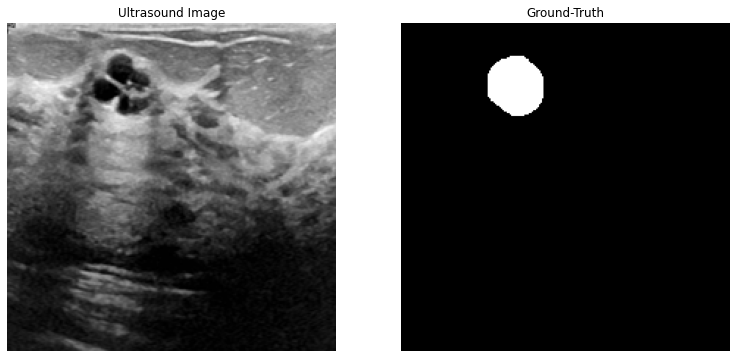

In [10]:
def show_image_mask(index, i, gt, pred=None, pred_exists=False, save_fig=False):
  plt.figure(figsize=(20, 10))

  plt.subplot(1, 3, 1)
  plt.imshow(i[index])
  plt.gca().set_title('Ultrasound Image')
  plt.grid(None)
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(gt[index], cmap='gray')
  plt.gca().set_title('Ground-Truth')
  plt.grid(None)
  plt.axis("off")

  if pred_exists:
    plt.subplot(1, 3, 3)
    plt.imshow(pred[index], cmap='gray')
    plt.gca().set_title('Predicted')
    plt.grid(None)
    plt.axis("off")

  plt.show()

  if save_fig:
    plt.savefig('Figure.png', bbox_inches='tight')

show_image_mask(15, X_train, M_train)

# Custom Transform

In [11]:
class SegTransform(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.ToTensor()
                                          ])

    image, mask = sample['image'], sample['mask']
    transformed_image = image_transformations(image)
    transformed_mask = image_transformations(mask.astype('float32'))

    transformed_sample = {
        'image': transformed_image,
        'mask': transformed_mask
    }
    return transformed_sample

# Custom Dataset

In [12]:
class SegDataset(Dataset):
  def __init__(self, images, masks, transform=SegTransform()):
    self.images = images
    self.masks = masks
    self.transform = transform
  
  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    image = self.images[index]
    mask = self.masks[index]    

    data = {'image':image, 'mask':mask}
    if self.transform:
      data = self.transform(data)
    return data

# Create Dataloaders

In [13]:
def seg_train_val_test_loaders(batch_size=BATCH_SIZE):   

  train_set = SegDataset(X_train, M_train)
  test_set = SegDataset(X_test, M_test)

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [14]:
s_train_loader, s_test_loader = seg_train_val_test_loaders(200)
for batch in s_train_loader:
  print(batch['image'].shape, batch['mask'].shape)

torch.Size([200, 3, 224, 224]) torch.Size([200, 1, 224, 224])
torch.Size([200, 3, 224, 224]) torch.Size([200, 1, 224, 224])
torch.Size([52, 3, 224, 224]) torch.Size([52, 1, 224, 224])


# U-Net Architecture

In [15]:
class Block(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
    self.relu  = nn.ReLU()
    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

  def forward(self, x):
    return self.conv2(self.relu(self.conv1(x)))

### Encoder

In [16]:
class Encoder(nn.Module):
  def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
    super().__init__()
    self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
    self.pool = nn.MaxPool2d(2)
  
  def forward(self, x):
    ftrs = []
    for block in self.enc_blocks:
        x = block(x)
        ftrs.append(x)
        x = self.pool(x)
    return ftrs

### Decoder

In [17]:
class Decoder(nn.Module):
  def __init__(self, chs=(1024, 512, 256, 128, 64)):
    super().__init__()
    self.chs = chs
    self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
    self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
      
  def forward(self, x, encoder_features):
    for i in range(len(self.chs)-1):
      x = self.upconvs[i](x)
      enc_ftrs = self.crop(encoder_features[i], x)
      x = torch.cat([x, enc_ftrs], dim=1)
      x = self.dec_blocks[i](x)
    return x

  def crop(self, enc_ftrs, x):
    _, _, H, W = x.shape
    enc_ftrs = transforms.CenterCrop([H, W])(enc_ftrs)
    return enc_ftrs

### U-Net

In [18]:
class UNet(nn.Module):
  def __init__(self, enc_chs=(3, 64, 128, 256, 512, 1024), dec_chs=(1024, 512, 256, 128, 64)):
    super().__init__()
    self.encoder = Encoder(enc_chs)
    self.decoder = Decoder(dec_chs)
    self.head = nn.Conv2d(dec_chs[-1], 1, 1)

  def forward(self, x):
    enc_ftrs = self.encoder(x)
    out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
    out = self.head(out)
    return out

In [19]:
model = UNet()
x = torch.randn(5, 3, 224, 224)
print(model(x).shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([5, 1, 224, 224])


# Train-Test Utils

In [20]:
def random_seed(i=0):
  torch.manual_seed(i)
  np.random.seed(i)
  random.seed(i)

  if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Dice Loss

In [21]:
class DiceLoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(DiceLoss, self).__init__()

  def forward(self, inputs, targets, smooth=1):
    
    inputs = torch.sigmoid(inputs)

    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = torch.sum(inputs * targets)                            
    dice = (2.*intersection + smooth)/(torch.sum(inputs) + torch.sum(targets) + smooth) 

    loss = 1 - dice
    return loss

### Test Function

In [22]:
def test_segmentation_model(model, test_loader, criterion, device):
  test_accuracy = 0
  test_loss = 0

  model.eval()
  for batch in test_loader:
    image_batch = batch['image'].to(device)
    mask_batch = batch['mask'].to(device)

    m_pred = model(image_batch)
    batch_loss = criterion(m_pred, mask_batch)

    output_masks = torch.sigmoid(m_pred).clone()
    output_masks[output_masks < 0.5] = 0
    output_masks[output_masks >= 0.5] = 1

    correct = mask_batch.eq(output_masks).cpu().numpy()
    test_accuracy += np.sum(correct, axis=(0,1,2,3))
    test_loss += batch_loss.item() * image_batch.size(0)

  average_testing_loss = test_loss / len(test_loader.sampler)
  average_testing_accuracy = test_accuracy / (len(test_loader.sampler)*RESIZE_DIM[0]*RESIZE_DIM[1])

  return average_testing_loss, average_testing_accuracy

### Training Function

In [23]:
def train_segmentation_model(model, train_loader, test_loader, optimizer, criterion, epochs, device, save_path):

  train_losses = []
  test_losses = []

  train_accuracies = []
  test_accuracies = []

  for epoch in range(epochs):
    train_loss = 0
    test_loss = 0

    train_accuracy = 0
    test_accuracy = 0

    model.train()
    for batch in train_loader:
      image_batch = batch['image'].to(device)
      mask_batch = batch['mask'].to(device)

      optimizer.zero_grad()
      m_pred = model(image_batch)
      batch_loss = criterion(m_pred, mask_batch)      
      
      batch_loss.backward()
      optimizer.step()

      output_masks = torch.sigmoid(m_pred).clone()
      output_masks[output_masks < 0.5] = 0
      output_masks[output_masks >= 0.5] = 1

      correct = mask_batch.eq(output_masks).cpu().numpy()
      train_accuracy += np.sum(correct, axis=(0, 1, 2, 3))
      train_loss += batch_loss.item() * image_batch.size(0)

    average_training_loss = train_loss / len(train_loader.sampler)
    average_training_accuracy = train_accuracy / (len(train_loader.sampler)*RESIZE_DIM[0]*RESIZE_DIM[1])

    average_testing_loss, average_testing_accuracy = test_segmentation_model(
        model, test_loader, 
        criterion, device
        )  
    
    train_losses.append(average_training_loss)
    test_losses.append(average_testing_loss)

    train_accuracies.append(average_training_accuracy)
    test_accuracies.append(average_testing_accuracy)   
  
    print('Epoch: {} \t Training Dice Loss: {:.4f} \t  Test Dice Loss: {:.4f} \t Training Pixel Acc: {:.4f} \t Test Pixel Acc: {:.4f}'.format(epoch, average_training_loss, average_testing_loss, average_training_accuracy, average_testing_accuracy))

  torch.save(model.state_dict(), save_path)
  print("Saving Model Weights !")
  return train_losses, test_losses, train_accuracies, test_accuracies

# Train Model

In [25]:
print("Training Model")
random_seed(0)

seg_model = UNet().to(DEVICE)

s_train_loader, s_test_loader = seg_train_val_test_loaders(batch_size=BATCH_SIZE)
criterion = DiceLoss()
optimizer = optim.Adam(seg_model.parameters(), lr=LEARNING_RATE)

save_path = 'UNET_WEIGHTS.pt'

train_dice_losses, test_dice_losses, pixel_train_accuracies, pixel_test_accuracies = train_segmentation_model(
      model=seg_model, 
      train_loader=s_train_loader,
      test_loader=s_test_loader, 
      optimizer=optimizer, 
      criterion=criterion, 
      epochs=EPOCHS, 
      device=DEVICE,
      save_path=save_path
      )

Training Model
Epoch: 0 	 Training Dice Loss: 0.8448 	  Test Dice Loss: 0.8077 	 Training Pixel Acc: 0.5820 	 Test Pixel Acc: 0.1144
Epoch: 1 	 Training Dice Loss: 0.8084 	  Test Dice Loss: 0.7769 	 Training Pixel Acc: 0.4012 	 Test Pixel Acc: 0.4143
Epoch: 2 	 Training Dice Loss: 0.7945 	  Test Dice Loss: 0.7160 	 Training Pixel Acc: 0.5160 	 Test Pixel Acc: 0.7320
Epoch: 3 	 Training Dice Loss: 0.7190 	  Test Dice Loss: 0.6810 	 Training Pixel Acc: 0.7850 	 Test Pixel Acc: 0.7717
Epoch: 4 	 Training Dice Loss: 0.6949 	  Test Dice Loss: 0.6633 	 Training Pixel Acc: 0.7832 	 Test Pixel Acc: 0.8855
Epoch: 5 	 Training Dice Loss: 0.6701 	  Test Dice Loss: 0.6387 	 Training Pixel Acc: 0.8629 	 Test Pixel Acc: 0.8763
Epoch: 6 	 Training Dice Loss: 0.6363 	  Test Dice Loss: 0.6055 	 Training Pixel Acc: 0.8455 	 Test Pixel Acc: 0.7951
Epoch: 7 	 Training Dice Loss: 0.5772 	  Test Dice Loss: 0.5482 	 Training Pixel Acc: 0.8870 	 Test Pixel Acc: 0.8757
Epoch: 8 	 Training Dice Loss: 0.4978 	  

# Loss & Accuracy Plots

In [31]:
def generate_curves(train, test, ticks=50, ylabel="Loss", xlabel="Epochs"):
  # filename = os.path.join("Results", filename)
  xticks = [int(i) for i in list(range(ticks))]
 
  plt.figure(figsize=(12, 6))
  sb.set(font_scale=1.2)

  plt.plot(xticks, train, 'r-', linewidth=3, label='Train Accuracy')
  plt.plot(xticks, test, 'g-', linewidth=3, label='Test Accuracy')
  
  plt.legend(loc='best')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xticks(ticks=list(range(0, ticks, 5)))
  # plt.savefig(filename + '_' + ylabel + '_.png', bbox_inches='tight')

  plt.show()

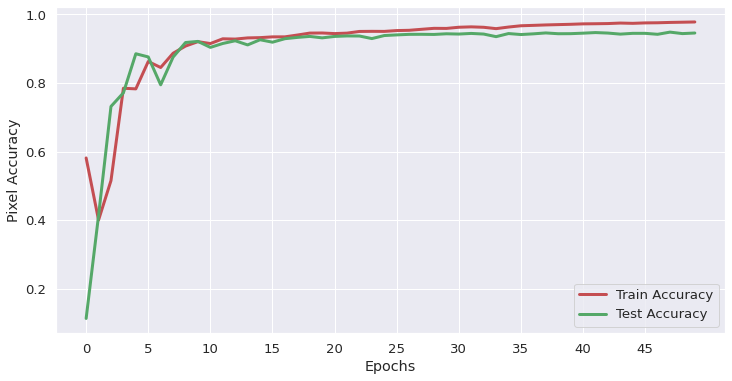

In [32]:
generate_curves(pixel_train_accuracies, pixel_test_accuracies, ticks=EPOCHS, ylabel="Pixel Accuracy", xlabel="Epochs")

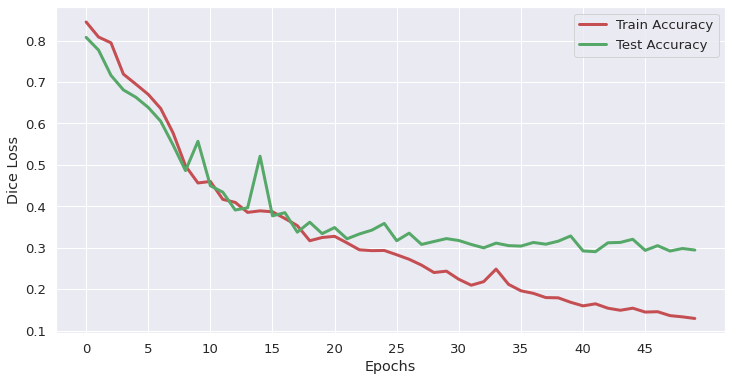

In [33]:
generate_curves(train_dice_losses, test_dice_losses, ticks=EPOCHS, ylabel="Dice Loss", xlabel="Epochs")

# Visualize Predicted Masks

In [34]:
seg_model = UNet().to(DEVICE)
seg_model.load_state_dict(torch.load('UNET_WEIGHTS.pt'))

for batch in s_test_loader:
  image_batch = batch['image'].to(DEVICE)
  mask_batch = batch['mask'].to(DEVICE)

  segmented_masks = seg_model(image_batch)

  output_masks = torch.sigmoid(segmented_masks).clone()
  output_masks[output_masks < 0.5] = 0
  output_masks[output_masks >= 0.5] = 1

  predicted_masks = output_masks.cpu().detach().numpy().squeeze(1)
  original_images = image_batch.permute(0, 2, 3, 1).cpu().numpy()
  original_masks = mask_batch.cpu().numpy().squeeze(1)

  print(original_images.shape, original_masks.shape, predicted_masks.shape)
  break

(20, 224, 224, 3) (20, 224, 224) (20, 224, 224)


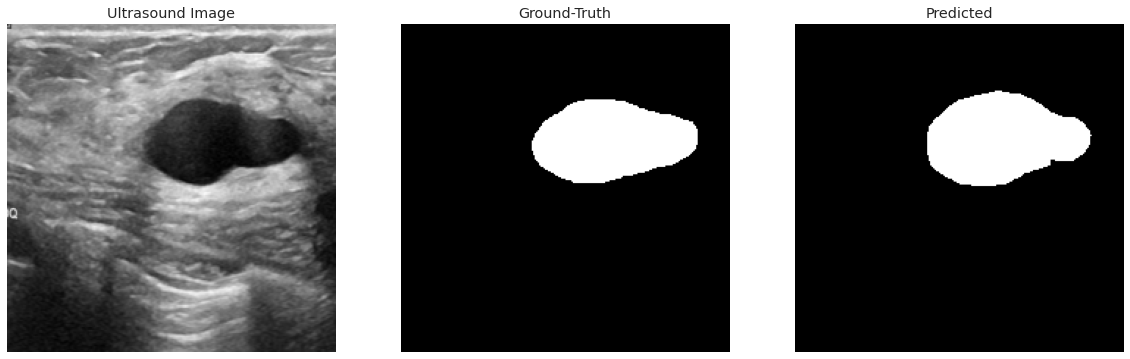

<Figure size 432x288 with 0 Axes>

In [40]:
show_image_mask(4, i=original_images, gt=original_masks, pred=predicted_masks, pred_exists=True, save_fig=True)